In [258]:
#import needed libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from time import time
import pickle
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tqdm import tqdm_notebook as tqdm
sns.set()
%matplotlib inline
import warnings
warning = [DeprecationWarning, FutureWarning, UserWarning]
for w in warning:
    warnings.filterwarnings("ignore", category=w)

In [92]:
#Windows beep at the ending of a task
import winsound
def done():
    frequency = 2000  
    duration = 400  
    return winsound.Beep(frequency, duration)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
#Let's look what is the size of the datasets 
print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (200000, 202)
Test Shape: (200000, 201)


In [4]:
pd.set_option('display.max_columns', None) #display all columns
pd.set_option('display.max_rows', None) #display all rows
train.head(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [5]:
# Total number of records
n_records = len(train)

# Number of records where the client made the transaction
made = train.target.sum()

# Number of records where the client didn't make the transaction
didnt_make = n_records - made

# Percentage of transaction made
percentage = made / n_records 

# Print the results
print("Total number of records: {}".format(n_records))
print("Clients that made the transaction: {}".format(made))
print("Clients that didn't make the transaction: {}".format(didnt_make))
print("Percentage of clients that made the transaction: {}%".format(percentage*100))

Total number of records: 200000
Clients that made the transaction: 20098
Clients that didn't make the transaction: 179902
Percentage of clients that made the transaction: 10.049%


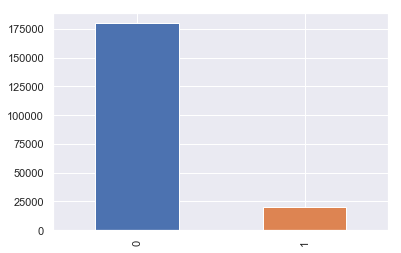

In [6]:
#Plot of distribution of 0 and 1 in the target
train.target.value_counts().plot.bar()

# Preprocessing the data

In [7]:
def drop_columns(dataset):
    columns = ['ID_code', 'target']
    for c in dataset.columns:
        if c in columns:
            dataset = dataset.drop(c, axis = 1)
    return dataset 

In [8]:
#Get a fraction of the data
def stratified_data(data, frac, random_state = None):
    strat_data = data.sample(frac = frac, random_state = random_state )
    y = strat_data['target']
    X = drop_columns(strat_data)
    return X, y

In [145]:
def Stand_Scaler(data):
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns= data.columns)
    return scaled_data

In [10]:
#Full features and targets datasets
y = train['target']
X = drop_columns(train)

In [11]:
from feature_selector import FeatureSelector

In [12]:
# Setting up the Feature Selector
fs = FeatureSelector(data = X, labels = y)

In [14]:
#Finding missing values
fs.identify_missing(missing_threshold=0.0)

0 features with greater than 0.00 missing values.



In [17]:
#Identifing collinear (highly correlated) features 
fs.identify_collinear(correlation_threshold = 0.95)

0 features with a correlation magnitude greater than 0.95.



In [20]:
"""
Finding Zero Importance Features
This method relies on a machine learning model to identify features to remove. 
It therefore requires a supervised learning problem with labels. 
The method works by finding feature importances using a gradient boosting machine implemented in the LightGBM
"""
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[763]	valid_0's binary_logloss: 0.209647	valid_0's auc: 0.893447
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[840]	valid_0's binary_logloss: 0.209365	valid_0's auc: 0.894397
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[975]	valid_0's binary_logloss: 0.210715	valid_0's auc: 0.890942
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[891]	valid_0's binary_logloss: 0.210591	valid_0's auc: 0.891652
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[986]	valid_0's binary_logloss: 0.214936	valid_0's auc: 0.886234
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[770]	valid_0's binary_logl

In [21]:
"""
Low Importance Features
This method builds off the feature importances from the gradient boosting machine (identify_zero_importance must be run first)
by finding the lowest importance features not needed to reach a specified cumulative total feature importance. For example, 
if we pass in 0.99, this will find the lowest important features that are not needed to reach 99% of the total feature importance.
"""

fs.identify_low_importance(cumulative_importance = 0.99)

192 features required for cumulative importance of 0.99 after one hot encoding.
8 features do not contribute to cumulative importance of 0.99.



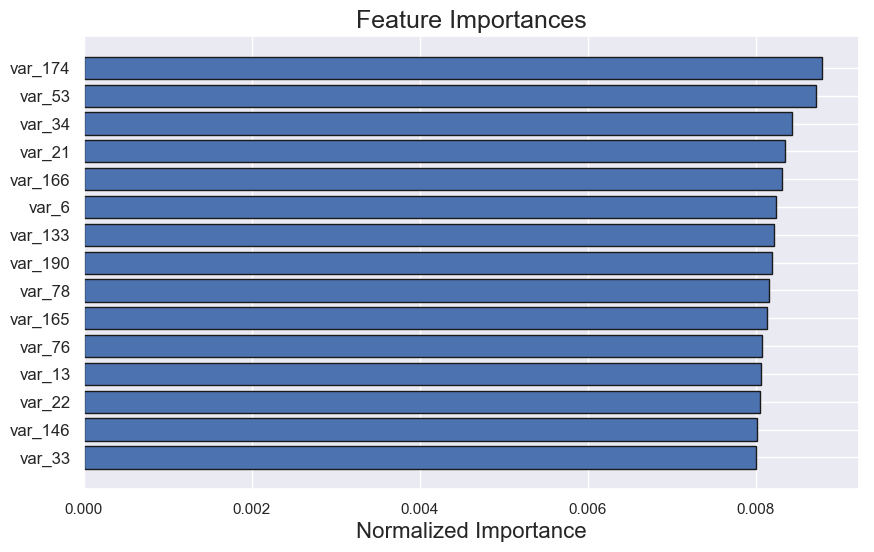

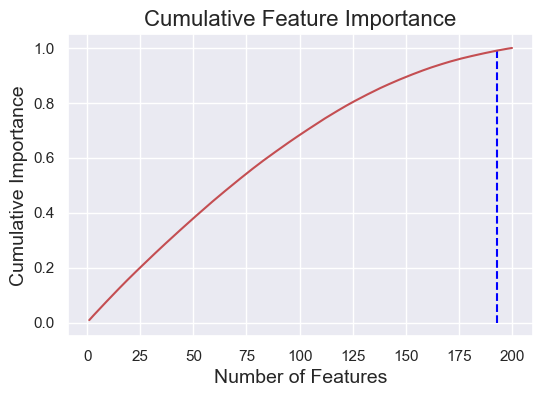

193 features required for 0.99 of cumulative importance


In [26]:
fs.plot_feature_importances(threshold = 0.99)

In [22]:
low_importance_features = fs.ops['low_importance']
low_importance_features[:]

['var_103',
 'var_30',
 'var_10',
 'var_158',
 'var_98',
 'var_185',
 'var_117',
 'var_17']

# Baseline Model

In [11]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [125]:
#Creating train, test, split and transforming into XGBoost Matrices
def get_splits(X,y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                      y,
                                      test_size = 0.15,
                                      random_state=0)
    return X_train, X_test, y_train, y_test

In [14]:
#Calculate the metrics of the model
def metrics(y_test, predictions, probabilities):
    cm = confusion_matrix(y_test, predictions)
    auc = round(roc_auc_score(y_test, probabilities), 4)
    fpr = round(100 * (cm[0][1]/(cm[0][0]+cm[0][1])))
    tpr = recall_score(y_test, predictions)
    ppv = precision_score(y_test, predictions)
    return cm, auc, fpr, tpr, ppv

In [15]:
#Dealing with imbalance dataset using ADASYN of Imblearn Package
sm = SMOTE(random_state=0, n_jobs = -1)

#### Baseline Model Training

In [27]:
%%time
results = {}
count = 0

X_train, X_test, y_train, y_test = get_splits(X, y)

X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

baseline_model = LogisticRegressionCV(cv = 10, penalty= 'l2', n_jobs=-1)
baseline_model.fit(X_train, y_train)

pred = baseline_model.predict(X_test)
proba = baseline_model.predict_proba(X_test)[:,1]

cm, auc, fpr, tpr, ppv = metrics(y_test, pred, proba)   
results[count] = {"TN": cm[0][0],
                  "FP": cm[0][1],
                  "FN": cm[1][0],
                  "TP": cm[1][1],
                  "AUC": auc,
                  "FPR": fpr,
                  "TPR": tpr,
                  "PPV": ppv
                 }
print("Done.")
sys.stdout.flush()

Done.
Wall time: 9.58 s


In [28]:
cols = ["TN", "FP", "FN","TP","FPR","TPR","PPV","AUC"]
df_results = pd.DataFrame(results).T[cols]
df_results

,TN,FP,FN,TP,FPR,TPR,PPV,AUC
0,10600.0,163.0,931.0,306.0,2.0,0.247373,0.652452,0.857


In [29]:
print("AUC Result: %", round(df_results.AUC.mean(),4))
print("FPR Result: %", round(df_results.FPR.mean(),4))
print("Recall Result: %", round(df_results.TPR.mean(),4))
print("Precision Result: %", round(df_results.PPV.mean(),4))

AUC Result: % 0.857
FPR Result: % 2.0
Recall Result: % 0.2474
Precision Result: % 0.6525


# XGBoost Model

## Hyperparameters Optimization

In [278]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

X, y = stratified_data(train, 0.4)

X = Stand_Scaler(X)

X_train, X_test, y_train, y_test = get_splits(X, y)

def objective(space):
    # Instantiate the classifier
    model = xgb.XGBClassifier(n_estimators =500,
                            n_jobs = -1,
                            colsample_bytree=space['colsample_bytree'],
                            learning_rate = space['learning_rate'],
                            max_depth = int(space['max_depth']),
                            scale_pos_weight = space['scale_pos_weight'],
                            tree_method= 'gpu_hist',
                            silent= 1,
                            objective = "binary:logistic"                            
                           )
    
    eval_set  = [( X_test, y_test)]
    
    # Fit the classsifier
    model.fit(X_train, y_train, eval_metric = 'auc',
              eval_set = eval_set,
              early_stopping_rounds = 500, verbose = 0)
    

    # Predict probabilities on training set
    probas = model.predict_proba(X_test)[:,1]
    
    # Calculate our Metric - AUC on testing set
    auc = roc_auc_score(y_test, probas)

    # return loss function.
    return {'loss': -auc, 'status': STATUS_OK }

In [279]:
space ={'max_depth': hp.quniform("max_depth", 2, 3, 1),
        'learning_rate': hp.quniform ('learning_rate', 0.01, 0.02, 0.01),
        'colsample_bytree' : hp.quniform ('colsample_bytree', 0.2,0.4,0.02),
        'scale_pos_weight' : hp.quniform('scale_pos_weight', 8,10,0.05),
    }

In [280]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print(best)
done()

100%|█████████████████████████████████████████████████| 100/100 [05:13<00:00,  3.17s/it, best loss: -0.839890041495104]
{'colsample_bytree': 0.24, 'learning_rate': 0.02, 'max_depth': 3.0, 'scale_pos_weight': 8.450000000000001}


In [281]:
#Setting up RepeatedStratifiedKFold
splits = 4
repeats = 2
iterations = splits * repeats
rskf = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=0)

In [282]:
%%time

results_xgb = {}
count = 0   

X, y = stratified_data(train,  0.6)

X = Stand_Scaler(X)

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    xgb_model = xgb.XGBClassifier( n_estimators =999999,
                            n_jobs = -1,
                            colsample_bytree= best['colsample_bytree'],
                            learning_rate = best['learning_rate'],
                            max_depth = int(best['max_depth']),
                            scale_pos_weight = best['scale_pos_weight'],
                            tree_method= 'gpu_hist',
                            silent= 1,
                            objective = "binary:logistic")

    eval_set  = [( X_test, y_test)]
    
    xgb_model.fit(X_train, y_train, eval_metric = 'auc',
                  eval_set = eval_set,
                  early_stopping_rounds = 1000, verbose = 0)

    pred = xgb_model.predict(X_test)
    probas = xgb_model.predict_proba(X_test)[:,1]

    cm, auc, fpr, tpr, ppv = metrics(y_test, pred, probas)   
    results_xgb[count] = {"TN": cm[0][0],
                      "FP": cm[0][1],
                      "FN": cm[1][0],
                      "TP": cm[1][1],
                      "AUC": auc,
                      "FPR": fpr,
                      "TPR": tpr,
                      "PPV": ppv
                     }
    count += 1
    print("\rTraining. {}/{}, AUC = {}".format(count,iterations, auc), end=" ")
    sys.stdout.flush()
    done()

Training. 8/8, AUC = 0.8902        Wall time: 7min


In [283]:
cols = ["TN", "FP", "FN","TP","FPR","TPR","PPV","AUC"]
df_results_xgb = pd.DataFrame(results_xgb).T[cols]
df_results_xgb

,TN,FP,FN,TP,FPR,TPR,PPV,AUC
0,23994.0,3020.0,918.0,2069.0,11.0,0.692668,0.406563,0.8899
1,24368.0,2646.0,929.0,2058.0,10.0,0.688986,0.437500,0.8932
2,24155.0,2858.0,854.0,2132.0,11.0,0.713999,0.427255,0.8969
3,24293.0,2720.0,910.0,2076.0,10.0,0.695244,0.432861,0.8950
4,24204.0,2810.0,857.0,2130.0,10.0,0.713090,0.431174,0.8960
5,24140.0,2874.0,913.0,2074.0,11.0,0.694342,0.419159,0.8917
6,24277.0,2736.0,885.0,2101.0,10.0,0.703617,0.434360,0.8990
7,24283.0,2730.0,920.0,2066.0,10.0,0.691896,0.430776,0.8902


In [284]:
df_results_xgb.describe()

,TN,FP,FN,TP,FPR,TPR,PPV,AUC
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,24214.250000,2799.250000,898.250000,2088.250000,10.375000,0.699230,0.427456,0.893988
std,117.195502,117.380638,29.275782,29.163333,0.517549,0.009791,0.010057,0.003286
min,23994.000000,2646.000000,854.000000,2058.000000,10.000000,0.688986,0.406563,0.889900
25%,24151.250000,2727.500000,878.000000,2068.250000,10.000000,0.692475,0.425231,0.891325
50%,24240.500000,2773.000000,911.500000,2075.000000,10.000000,0.694793,0.430975,0.894100
75%,24285.500000,2862.000000,918.500000,2108.250000,11.000000,0.705985,0.433236,0.896225
max,24368.000000,3020.000000,929.000000,2132.000000,11.000000,0.713999,0.437500,0.899000


numpy.ndarray

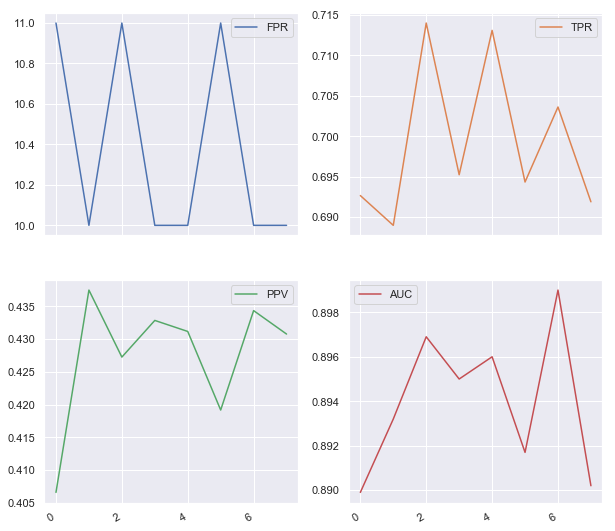

In [285]:
axes = df_results_xgb[["FPR","TPR","PPV","AUC"]].plot(subplots=True, layout=(2,2), figsize = (10,10))
type(axes)

In [286]:
print("Average AUC Result: %", round(df_results_xgb.AUC.mean(),4))
print("Average FPR Result: %", round(df_results_xgb.FPR.mean(),4))
print("Average TPR Result: %", round(df_results_xgb.TPR.mean(),4))
print("Average PPV Result: %", round(df_results_xgb.PPV.mean(),4))

Average AUC Result: % 0.894
Average FPR Result: % 10.375
Average TPR Result: % 0.6992
Average PPV Result: % 0.4275


In [287]:
#saving the model
filename = 'finalized_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

## Training and Validation

## Feature Importances

In [300]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
ceate_feature_map(X)

In [301]:
def itemgetter(*items):
    if len(items) == 1:
        item = items[0]
        def g(obj):
            return obj[item]
    else:
        def g(obj):
            return tuple(obj[item] for item in items)
    return g

In [302]:
importance = xgb_model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore_ratio'] = df['fscore'] / df['fscore'].sum()
feat_imp = df.sort_values(by=['fscore'],ascending=False )
feat_imp.head(10)

AttributeError: 'XGBClassifier' object has no attribute 'get_fscore'

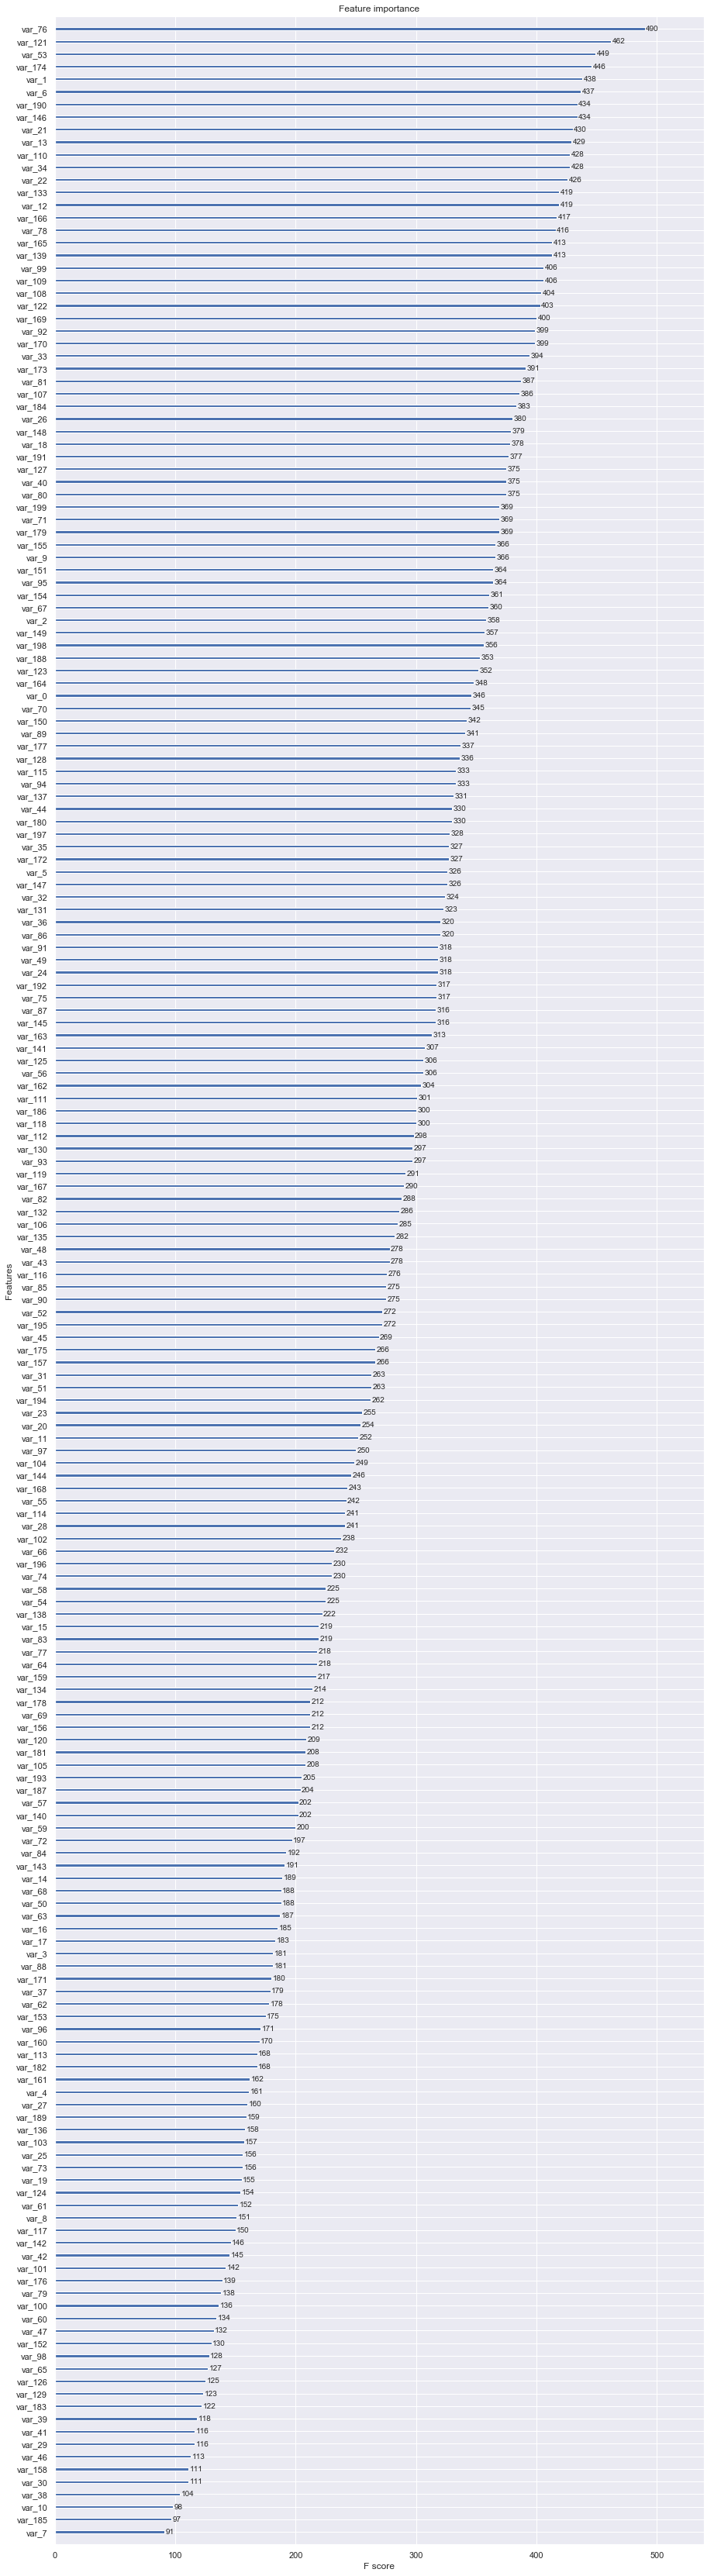

In [304]:
def my_plot_importance(booster, figsize, **kwargs): 
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
my_plot_importance(xgb_model, (15,60))

## Model ROC Curve

In [305]:
roc_values = []
for thresh in np.linspace(0, 1, 101):
    preds = get_preds(probas, thresh)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)

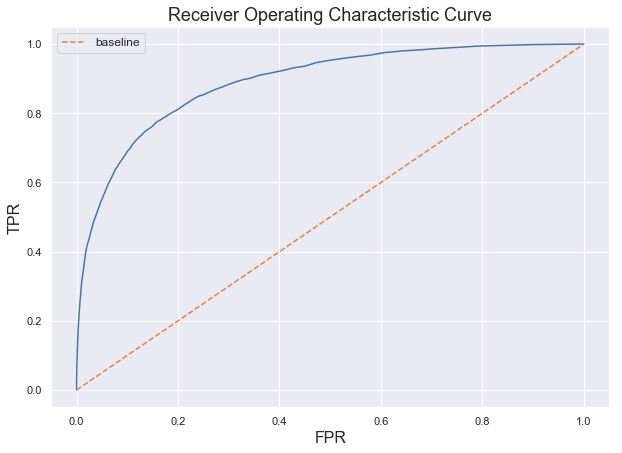

In [306]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

# Submission

In [296]:
# load the model from disk
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [297]:
def transform_data(data):
    final_data = drop_columns(data)
    final_data = Stand_Scaler(final_data)
    return final_data

In [298]:
def make_csv(data, model):
    preds_final = model.predict_proba(data)[:,1]
    predictions = pd.Series(preds_final, index = test['ID_code'], name = 'target')
    return predictions.to_csv("submission.csv", header = True)

In [299]:
test_data_final = transform_data(test)
make_csv(test_data_final, loaded_model)

### Submission Score: **0.89702** Leaderboard ~4693